# HoVer-Net Output Notebook

This repository enables the segmentation of nuclei in H&E whole-slide images (WSIs). For inference, we have incorporated two modes:

- Tile processing mode
- WSI processing mode

For tile processing, the input must be in a standard image format, such as `.jpg` or `.png`. <br />
For WSI processing, the input must be an [OpenSlide](https://openslide.org/) supported whole-slide image.

- Both tile and wsi processing modes output a `.json` file that contains:
        - bounding box coordinates for each nucleus
        - centroid coordinates for each nucleus
        - contour coordinates for each nucleus 
        - nucleus type predictions
        - per class probabilities for each nucleus (optional)
- tile mode also output a `.mat` and overlay file. The `.mat` file contains:
        - raw output of network (optional)
        - instance map containing values from 0 to N, where N is the number of nuclei
        - list of length N containing predictions for each nucleus
- wsi mode also produces a low resolution thumbnail and a tissue mask

In this notebook, we demonstrate how to utilise the output generated by these two different settings.

In [14]:
# load the libraries

import sys
sys.path.append('../')

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import scipy.io as sio
# !pip install opencv-python

import cv2
import json
# import openslide

# from misc.wsi_handler import get_file_handler
from misc.viz_utils import visualize_instances_dict

     |████████████████████████████████| 46.4 MB 2.8 MB/s eta 0:00:011   |▊                               | 1.0 MB 1.3 MB/s eta 0:00:36


In [137]:
# first, we shall set the image tile, WSI and output paths.

tile_path = '../dataset/Lymphocyte/Test/Images/'
tile_json_path = '../out/Lymphocyte/pannuke_lymph_50_fix/json/'
tile_mat_path = '../out/Lymphocyte/pannuke_lymph_50_fix/mat/'
tile_overlay_path = '../out/Lymphocyte/pannuke_lymph_50_fix/overlay/'

# wsi_path = '../dataset/sample_wsis/wsi/'
# wsi_json_path = '../dataset/sample_wsis/out/'

## Tile Processing Output

First let's view the 2D output from tile processing mode, that is stored in a `.mat` file.

In [205]:
# load the original image, the `.mat` file and the overlay

image_list = glob.glob(tile_path + '*.jpg')
image_list.sort()

# get a random image 
# rand_nr = np.random.randint(0,len(image_list))
rand_nr = 3
image_file = image_list[rand_nr]

basename = os.path.basename(image_file)
image_ext = basename.split('.')[-1]
basename = basename[:-(len(image_ext)+1)]

image = cv2.imread(image_file)
# convert from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get the corresponding `.mat` file 
result_mat = sio.loadmat(tile_mat_path + basename + '.mat')

# get the overlay
overlay = cv2.imread(tile_overlay_path + basename + '.png')
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

In [206]:
# ** now, let's get the outputs and print some basic shape information
# 2D map where each nucleus has a unique ID assigned. 0 is background
inst_map = result_mat['inst_map'] 
# Nx2 length array denoting nuclear type predictions. N is the number of nuclei
# idx=0 denotes the corresponding inst_id in the `inst_map` and 
# idx=1 denotes the type of that inst_id
inst_type = result_mat['inst_type'] 
print(inst_type.shape)

print('instance map shape', inst_map.shape)
# double check the number of instances is the same as the number of type predictions
print('number of instances', len(np.unique(inst_map)[1:].tolist()))
print('number of type predictions', len(np.unique(inst_type)))
print('overlay shape', overlay.shape)

(2312, 1)
instance map shape (2048, 2880)
number of instances 2312
number of type predictions 6
overlay shape (2048, 2880, 3)


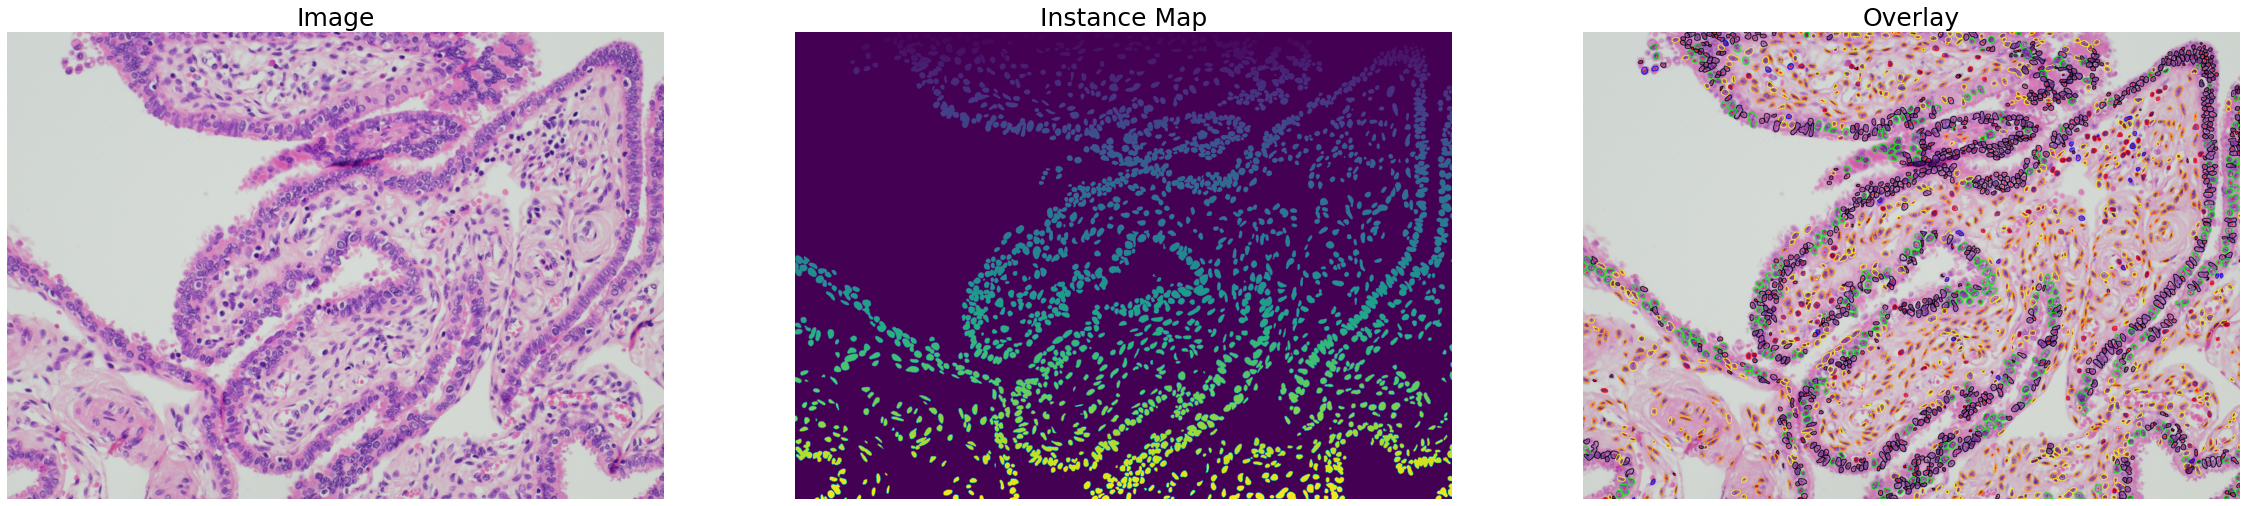

In [207]:
# plot the original image, along with the instance map and the overlay

plt.figure(figsize=(40,20))

plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.title('Image', fontsize=25)

plt.subplot(1,3,2)
plt.imshow(inst_map)
plt.axis('off')
plt.title('Instance Map', fontsize=25)

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.axis('off')
plt
plt.title('Overlay', fontsize=25)

plt.show()

In [142]:
# let's inspect the inst_type output

print(np.unique(inst_type))

[0 1 2 3 4 5]


We observe that the values range from 0 (background) to N where N is the number of classes. See below what these values refer to for different datasets.

## CoNSeP

1) Epithelial <br />
2) Inflammatory <br />
3) Spindle-Shaped <br />
4) Miscellaneous

## PanNuke

1) Neoplastic <br />
2) Inflammatory <br />
3) Connective <br />
4) Dead <br />
5) Non-Neoplastic Epithelial 

## MoNuSAC

1) Epithelial <br />
2) Lymphocyte <br />
3) Macrophage <br />
4) Neutrophil

**In this example we use a checkpoint trained on the PanNuke dataset**

Now, let's view the contents of the `.json` file.

In [20]:
# load the json file and add the contents to corresponding lists

json_path = tile_json_path + basename + '.json'

bbox_list = []
centroid_list = []
contour_list = [] 
type_list = []

with open(json_path) as json_file:
    data = json.load(json_file)
    mag_info = data['mag']
    nuc_info = data['nuc']
    for inst in nuc_info:
        inst_info = nuc_info[inst]
        inst_centroid = inst_info['centroid']
        centroid_list.append(inst_centroid)
        inst_contour = inst_info['contour']
        contour_list.append(inst_contour)
        inst_bbox = inst_info['bbox']
        bbox_list.append(inst_bbox)
        inst_type = inst_info['type']
        type_list.append(inst_type)

In [21]:
# get the number of items in each list

print('Number of centroids', len(centroid_list))
print('Number of contours', len(contour_list))
print('Number of bounding boxes', len(bbox_list))

# each item is a list of coordinates - let's take a look!
print('-'*60)
print(centroid_list[0])
print('-'*60)
print(contour_list[0])
print('-'*60)
print(bbox_list[0])

Number of centroids 827
Number of contours 827
Number of bounding boxes 827
------------------------------------------------------------
[386.70958083832335, 7.482035928143713]
------------------------------------------------------------
[[370, 0], [369, 1], [368, 1], [368, 2], [367, 3], [366, 3], [366, 4], [365, 5], [365, 6], [364, 7], [364, 10], [366, 12], [366, 13], [367, 13], [368, 14], [371, 14], [372, 15], [388, 15], [389, 16], [392, 16], [393, 15], [394, 16], [395, 16], [396, 15], [400, 15], [401, 14], [403, 14], [404, 13], [405, 13], [407, 11], [408, 11], [408, 10], [409, 9], [409, 5], [407, 3], [407, 1], [406, 0], [376, 0], [375, 1], [374, 0], [373, 1], [372, 1], [371, 0]]
------------------------------------------------------------
[[0, 364], [17, 410]]


In [22]:
# get a single contour, bounding box and centroid and visualise

rand_nucleus = np.random.randint(0, len(centroid_list))
rand_centroid = centroid_list[rand_nucleus]
rand_bbox = bbox_list[rand_nucleus]
rand_contour = contour_list[rand_nucleus]

# draw the overlays
overlay = image.copy()
overlay = cv2.drawContours(overlay.astype('uint8'), [np.array(rand_contour)], -1, (255,255,0), 1)
overlay = cv2.circle(overlay.astype('uint8'),(np.round(rand_centroid[0]).astype('int'), np.round(rand_centroid[1]).astype('int')), 3, (0,255,0), -1)
overlay = cv2.rectangle(overlay.astype('uint8'), (rand_bbox[0][1], rand_bbox[0][0]), (rand_bbox[1][1], rand_bbox[1][0]), (255,0,0), 1)

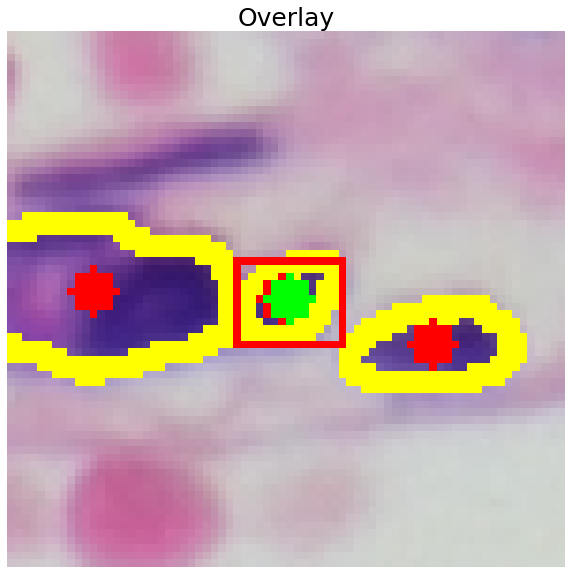

In [23]:
# plot the cropped overlay

pad = 30
crop1 = rand_bbox[0][0]-pad
if crop1 < 0: 
    crop1 = 0
crop2 = rand_bbox[1][0]+pad
if crop2 > overlay.shape[0]: 
    crop2 = overlay.shape[0]
crop3 = rand_bbox[0][1]-pad
if crop3 < 0: 
    crop3 = 0
crop4 = rand_bbox[1][1]+pad
if crop4 > overlay.shape[1]: 
    crop4 = overlay.shape[1]
crop_overlay = overlay[crop1:crop2,crop3:crop4,:]
plt.figure(figsize=(10,10))

plt.imshow(crop_overlay)
plt.axis('off')
plt.title('Overlay', fontsize=25)
plt.show()

## Compute classification accuracy

In [208]:
# load mat file for true labels

true_mat_path = '../dataset/Lymphocyte/Test/Labels/'
true_mat = sio.loadmat(true_mat_path + basename + '.mat')

pred_type_path = '../out/Lymphocyte/pannuke_lymph_50_fix/type_map/'
pred_type_map = sio.loadmat(pred_type_path + basename + '_type_map.mat')
pred_type_map = pred_type_map['type_map']

In [209]:
# ** now, let's get the outputs and print some basic shape information
# 2D map where each nucleus has a unique ID assigned. 0 is background
true_inst_map = true_mat['inst_map'] 
# Nx2 length array denoting nuclear type predictions. N is the number of nuclei
# idx=0 denotes the corresponding inst_id in the `inst_map` and 
# idx=1 denotes the type of that inst_id
true_inst_type = true_mat['type_map'] 
print(np.amax(true_inst_type))


print('instance map shape', true_inst_map.shape)
# double check the number of instances is the same as the number of type predictions
print('number of instances', len(np.unique(true_inst_map)[1:].tolist()))
print('number of type predictions', len(np.unique(true_inst_type)))

5
instance map shape (2048, 2880)
number of instances 62
number of type predictions 6


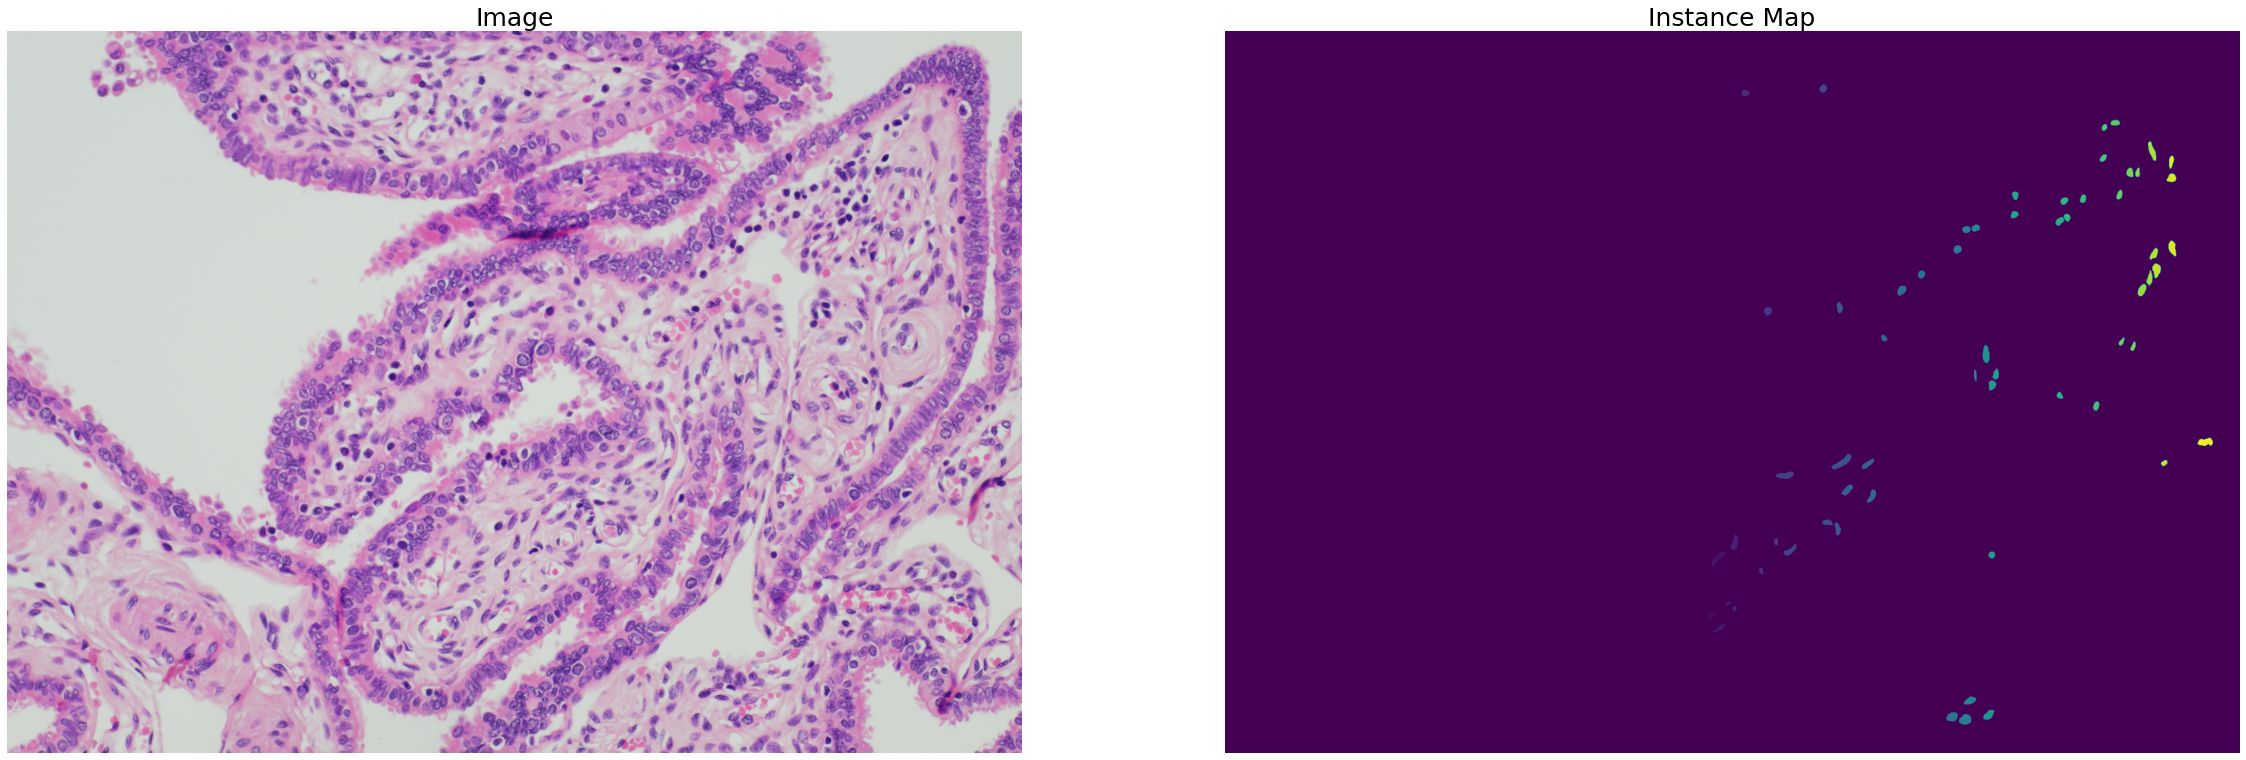

In [210]:
# plot the original image, along with the instance map and the overlay

plt.figure(figsize=(40,20))

plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.title('Image', fontsize=25)

plt.subplot(1,2,2)
plt.imshow(true_inst_map)
plt.axis('off')
plt.title('Instance Map', fontsize=25)

plt.show()

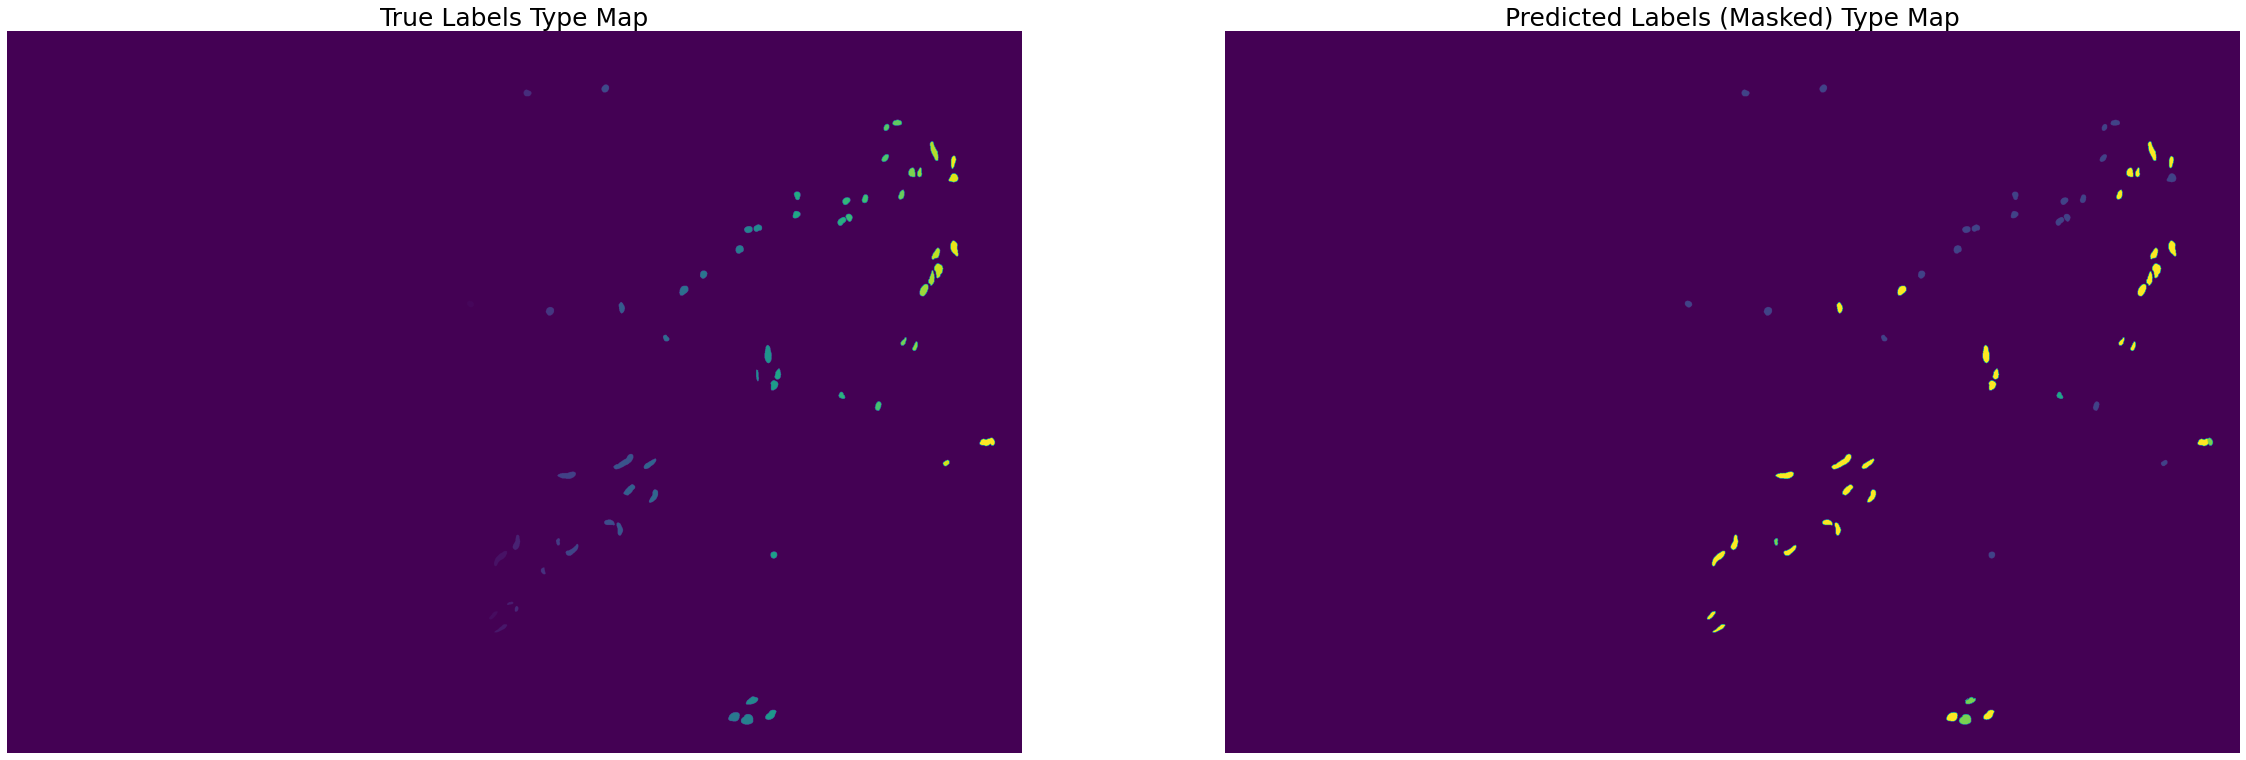

In [211]:
# only classify where we have ground truth labels

copy = np.copy(true_inst_type)

mask = copy > 0
binary_mask = copy
binary_mask[mask] = 1

pred_masked = binary_mask * pred_type_map

plt.figure(figsize=(40,20))

plt.subplot(1,2,1)
plt.imshow(true_inst_map)
plt.axis('off')
plt.title('True Labels Type Map', fontsize=25)

plt.subplot(1,2,2)
plt.imshow(pred_masked)
plt.axis('off')
plt.title('Predicted Labels (Masked) Type Map', fontsize=25)

plt.show()

In [212]:
# now go through the true labels and compare to predicted regions
# pixel wise comparison, or compare the whole segmentations to each other?
# build confusion matrix
from sklearn.metrics import confusion_matrix
labeled_ind = np.where(true_inst_type > 0)

# print(labeled_ind)
y_true = true_inst_type[labeled_ind]
y_pred = pred_masked[labeled_ind]

cm = confusion_matrix(y_true, y_pred)

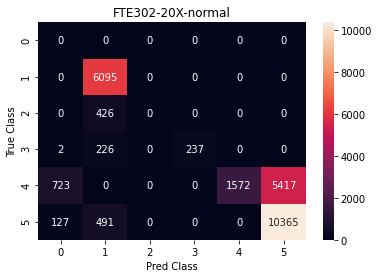

In [213]:
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='.5g')
plt.xlabel('Pred Class')
plt.ylabel('True Class')
plt.title(basename)
fn = basename + '-50.png'
plt.savefig(fn)